In [3]:
import numpy
from typing import Optional, Tuple, List
from collections import namedtuple
import matplotlib.pyplot as plt

In [4]:

MMOrder = namedtuple("MMOrder", ["size", "price"])

In [5]:
class CFMMarketMaker:
    def __init__(
        self,
        initial_price: float = 100,
        price_width_below: float = 0.05,
        price_width_above: float = 0.05,
        margin_usage_at_bound_above: float = 0.8,
        margin_usage_at_bound_below: float = 0.8,
        volume_per_side: float = 10,
        num_levels: int = 25,
        tick_spacing: float = 1,
    ):
        self.base_price = initial_price
        self.upper_price = (1 + price_width_above) * initial_price
        self.lower_price = (1 - price_width_below) * initial_price

        self.base_price_sqrt = initial_price**0.5
        self.upper_price_sqrt = self.upper_price**0.5
        self.lower_price_sqrt = self.lower_price**0.5

        self.lower_liq_factor = 1 / (self.base_price_sqrt - self.lower_price_sqrt)
        self.upper_liq_factor = 1 / (self.upper_price_sqrt - self.base_price_sqrt)

        self.margin_usage_at_bound_above = margin_usage_at_bound_above
        self.margin_usage_at_bound_below = margin_usage_at_bound_below

        self.tick_spacing = tick_spacing
        self.num_levels = num_levels
        self.volume_per_side = volume_per_side

    def initialise(
        self,
        vega,
    ):
        risk_factors = vega.get_risk_factors(self.market_id)
        self.short_factor, self.long_factor = risk_factors.short, risk_factors.long

    def _quantity_for_move(
        self,
        start_price_sqrt,
        end_price_sqrt,
        range_upper_price_sqrt,
        liquidity_factor,
    ) -> Optional[float]:
        if liquidity_factor == 0:
            return None
        start_fut_pos = (
            liquidity_factor
            * (range_upper_price_sqrt - start_price_sqrt)
            / (start_price_sqrt * range_upper_price_sqrt)
        )
        end_fut_pos = (
            liquidity_factor
            * (range_upper_price_sqrt - end_price_sqrt)
            / (end_price_sqrt * range_upper_price_sqrt)
        )

        return abs(start_fut_pos - end_fut_pos)

    def _generate_shape(
        self, bid_price_depth: float, ask_price_depth: float
    ) -> Tuple[List[MMOrder], List[MMOrder]]:
        return self._generate_shape_calcs(
            balance=sum(
                a.balance
                for a in self.vega.get_accounts_from_stream(
                    key_name=self.key_name,
                    wallet_name=self.wallet_name,
                    market_id=self.market_id,
                )
            ),
            average_entry=(
                self.vega.positions_by_market(
                    wallet_name=self.wallet_name,
                    market_id=self.market_id,
                    key_name=self.key_name,
                ).average_entry_price
                if self.current_position != 0
                else 0
            ),
            position=self.current_position,
        )

    def _generate_shape_calcs(
        self,
        balance: float,
        average_entry: float,
        position: float,
    ) -> Tuple[List[MMOrder], List[MMOrder]]:
        volume_at_upper = (
            self.margin_usage_at_bound_above
            * (balance / self.short_factor)
            / self.upper_price
        )

        volume_at_lower = (
            self.margin_usage_at_bound_below
            * (balance / self.long_factor)
            / self.lower_price
        )

        upper_L = (
            (
                self.margin_usage_at_bound_above
                * (balance / self.short_factor)
                / self.upper_price
            )
            * self.upper_price_sqrt
            * self.base_price_sqrt
            / (self.upper_price_sqrt - self.base_price_sqrt)
        )

        # lower_L = (
        #     self.margin_usage_at_bound_below
        #     * (balance / self.long_factor)
        #     * self.lower_liq_factor
        # )

        lower_L = (
            volume_at_lower
            * self.lower_price_sqrt
            * self.base_price_sqrt
            / (self.base_price_sqrt - self.lower_price_sqrt)
        )

        if position > 0:
            L = lower_L
            usd_total = self.margin_usage_at_bound_below * balance / self.long_factor
            lower_bound = self.lower_price_sqrt
            upper_bound = self.base_price_sqrt
            virt_x = abs(position) + L / upper_bound
            virt_y = (usd_total - abs(position) * average_entry) + L * lower_bound
        else:
            L = upper_L
            lower_bound = self.base_price_sqrt
            upper_bound = self.upper_price_sqrt
            virt_x = (volume_at_upper + position) + L / upper_bound
            virt_y = (abs(position) * average_entry) + L * lower_bound
        if L == 0:
            ref_price = self.base_price
        else:
            ref_price = virt_y / virt_x

        return self._calculate_price_levels(
            ref_price=ref_price,
            balance=balance,
            upper_L=upper_L,
            lower_L=lower_L,
            position=position,
        )

    def _calculate_liq_val(
        self, margin_frac: float, balance: float, risk_factor: float, liq_factor: float
    ) -> float:
        return margin_frac * (balance / risk_factor) * liq_factor

    def _calculate_price_levels(
        self,
        ref_price: float,
        balance: float,
        upper_L: float,
        lower_L: float,
        position: float,
    ) -> Tuple[List[MMOrder], List[MMOrder]]:
        if ref_price == 0:
            ref_price = self.curr_price

        agg_bids = []
        agg_asks = []

        pos = position

        for i in range(1, self.num_levels):
            pre_price_sqrt = (ref_price + (i - 1) * self.tick_spacing) ** 0.5
            price = ref_price + i * self.tick_spacing

            if price > self.upper_price or price < self.lower_price:
                continue

            volume = self._quantity_for_move(
                pre_price_sqrt,
                price**0.5,
                self.upper_price_sqrt if pos < 0 else self.base_price_sqrt,
                upper_L if pos < 0 else lower_L,
            )
            if volume is not None:
                if pos > 0 and pos - volume < 0:
                    volume = pos
                agg_asks.append(MMOrder(volume, price))
                pos -= volume

        pos = position
        for i in range(1, self.num_levels):
            pre_price_sqrt = (ref_price - (i - 1) * self.tick_spacing) ** 0.5
            price = ref_price - i * self.tick_spacing

            if price > self.upper_price or price < self.lower_price:
                continue

            volume = self._quantity_for_move(
                pre_price_sqrt,
                price**0.5,
                self.upper_price_sqrt if pos < 0 else self.base_price_sqrt,
                upper_L if pos < 0 else lower_L,
            )
            if volume is not None:
                if pos < 0 and pos + volume > 0:
                    volume = pos
                agg_bids.append(MMOrder(volume, price))
                pos += volume

        return agg_bids, agg_asks

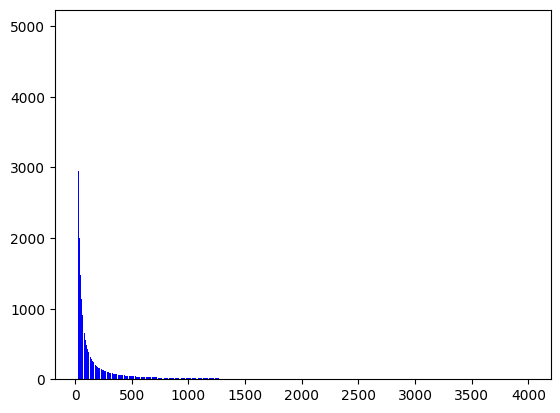

In [13]:

mm = CFMMarketMaker(
    initial_price=2000,
    price_width_above=1,
    price_width_below=0.99,
    margin_usage_at_bound_above=0.8,
    margin_usage_at_bound_below=0.8,
    num_levels=2000,
    tick_spacing=1,
)

balance = 100_000

mm.short_factor = 0.02
mm.long_factor = 0.02

volume_at_upper = (
    mm.margin_usage_at_bound_above * (balance / mm.short_factor) / mm.upper_price
)
volume_at_lower = (
    mm.margin_usage_at_bound_below * (balance / mm.long_factor) / mm.lower_price
)
upper_L = (
    volume_at_upper
    * mm.upper_price_sqrt
    * mm.base_price_sqrt
    / (mm.upper_price_sqrt - mm.base_price_sqrt)
)

lower_L = (
    volume_at_lower
    * mm.base_price_sqrt
    * mm.lower_price_sqrt
    / (mm.base_price_sqrt - mm.lower_price_sqrt)
)

# lower_L = (
#     mm.margin_usage_at_bound_below
#     * (balance / mm.long_factor)
#     * mm.lower_liq_factor
# )

to_price = 2000
pos = mm._quantity_for_move(
    mm.base_price_sqrt,
    to_price**0.5,
    mm.base_price_sqrt if to_price < mm.base_price else mm.upper_price_sqrt,
    lower_L,
)

bids, asks = mm._generate_shape_calcs(
    balance=balance, average_entry=to_price, position=pos
)

# x = []
# y = []

# cumsum = 0
# for bid in bids:
#     x.append(bid.price)
#     cumsum += bid.size
#     y.append(cumsum)

# plt.plot(x, y, color="blue")
x = []
y = []

# cumsum = 0
# for ask in asks:
#     x.append(ask.price)
#     cumsum += ask.size
#     y.append(cumsum)
# plt.plot(x, y, color="red")
# plt.show()

cumsum = 0
for bid in bids:
    x.append(bid.price)
    cumsum += bid.size
    y.append(bid.size)

plt.bar(x, y, color="blue")
x = []
y = []

cumsum = 0
for ask in asks:
    x.append(ask.price)
    cumsum += ask.size
    y.append(ask.size)
plt.bar(x, y, color="red")
plt.show()

